# 15688 Final Report: Intrinsic Clue for Tweet Popularity
#### Shangjie Chen, Weizi Wang, Xiaowei Lu

## Content
- [Introduction](#Introduction)
- [Related Work](#Related-Work)
- [Modeling](#Modeling)
- [Experiment](#Experiment)
- [Future Work](#Future-Work)

## Introduction 

[Twitter](https://twitter.com/) is nowadays one of the most popular social apps where vast quantity of information spread through it everyday. Unsurprisingly, event propagation, advertisement marketing and so on can also benefit well from the information spreading in Twitter. The retweet count, which measures the way of information spreading is a useful metric to evaluate the effectiveness of the tweet propagation. A tweet with high retweet count would definitely contribute to the propagation. Hence, a tool that can distinuish which tweets would have more retweet counts would help tweet more optimally very well and hereby helps achieve better propagation.

More specificly, although we all know that the follower count of the twitter author will probably have most impact on the retweet counts of a given tweet, it is not reasonable to use user features like this in the tool, since we cannot assume the user of the tool can ask any specific twitter author to post the tweet. Thus, in this project,to better serve our goal, we would like to build a tool to predict whether a given tweet will have more retweet count given only the tweet itself.

## Related Work
Several previous researchs are related to retweet prediction. Some works focus on predicting whether a specific user will retweet a given tweet. For example, in [Liangjie et al](http://www.cse.lehigh.edu/~brian/pubs/2012/WIN/retweet-prediction.pdf), the author used Factorization Machine to predict whether a specific user will retweet a tweet. Many experiments show models for such individual prediction achieve wonderful performance. However, such individual prediction is not very helpful since we care more about the aggregated impact of the tweet to all people who see it.
  
Other researchs focus on predicting the retweet count directly. In [Sean et al](https://sites.google.com/site/learningtweetvalue/home) , the author scores each tweet based on the relative retweet count to the baseline estimator. Then each word is assigned a score determined by the average score of all the tweets that contain this word. The score of a new tweet is then just the average score of all the words in that tweet and is used to predict the retweet count. In addition, [Qi et al](https://dl.acm.org/citation.cfm?id=2983809) used attention-based deep neural network to do retweet prediction. On the other hand, feature engineering is critical according to [Sasa et al](http://cs.wellesley.edu/~trails/retweetpapers/papers/RTToWin.pdf). They did thorough investigation on the retweet model and found that the prediction performance is dominated by social features, but tweet features also add a substantial boost.  The problem of these approaches is that the retweet count is highly relevant to the user, which, due to the issue we discussed before, will not be useful for the tool we are going to develop, when we cannot assume the user of the tool can ask any specific twitter author to post the tweet. Therefore, instead of predicting the absolute value of retweet count, we are trying to predict the relative popularity of the tweet compared to the median retweet count of tweets with same author, which will eliminate the effect of specific users and make more sense.

## Modeling

We define those tweets that have 2 times retweet count as the median retweet count of the same author's tweets as popular tweets. Therefore our task can be taken as a binary classification problem, which can be solved by many modern machine learning models.



In [3]:
import pandas as pd
import collections
from sklearn.ensemble import RandomForestClassifier

import re
import numpy as np
from datetime import datetime 
from nltk.tokenize import word_tokenize
import data_io,SIF_embedding
import scipy
import kmeans
import natural_language_processing


import matplotlib
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Random Forest
Random Forest is a widely-used tree-based ensemble model. It builds the model from a sample drawn with replacement from the training set, and each split picked is the best split among a random subset of the features. With randomness, the bias of the forest usually slightly increases but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.
We use [scikit-learn's](http://scikit-learn.org/stable/modules/ensemble.html#random-forests) implementation of Random Forest to build the model, with 300 estimators.

### SIF Sentece Embedding
 [SIF sentence embedding](https://github.com/PrincetonML/SIF/tree/master/src) is a powerful technique to generate semantic-related sentences vectors. The key algorithm for SIF Sentece Embedding is shown as below:
![sif_embedding](https://s1.ax1x.com/2018/05/03/CYHSSI.jpg)
Specifically, 
-	It uses [GloVe Vector](https://nlp.stanford.edu/projects/glove/) as the technique to generate vectors for each word, where GloVe utilizes the ratios of word-word co-occurrence probabilities and learns word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence.
-	Then it uses the occurence frequencies for each word in a corpus of Wikipedia to estimate the weights of each word and calculate a weighted average vector on all word vectors for the sentence as the initial sentence vector.
-	Finally, with a matrix containing all sentence vectors, we extract the first principal component from it and calculate the updated sentence vectors based on the component.
-	In general, sentences with similar vectors are often similar to each other in semantic sense.

Related datasets can be downloaded using following links.
- [Glove vectors built on tweets](https://drive.google.com/file/d/1vwCsvqKRYbrZLD6gxWwoGymY8QcVW4dw/view?usp=sharing)
- [Wikipedia word frequencies](https://drive.google.com/file/d/1vwCsvqKRYbrZLD6gxWwoGymY8QcVW4dw/view?usp=sharing)

In [4]:
wordfile = 'glove.twitter.27B/glove.twitter.27B.100d.txt' # word vector file, can be downloaded from GloVe website
weightfile = 'enwiki_vocab_min200.txt' # each line is a word and its frequency
weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 1 # number of principal components to remove in SIF weighting scheme
# load word vectors
(words, We) = data_io.getWordmap(wordfile)
# load word weights
word2weight = data_io.getWordWeight(weightfile, weightpara) # word2weight['str'] is the weight for the word 'str'
weight4ind = data_io.getWeight(words, word2weight) # weight4ind[i] is the weight for the i-th word
# load sentences

### Feature Generation
Before diving into the problem, we need to do some basic data preprocessings and cleanings. After the preprocessings, we can then extract features for our task.

#### Data Preprocessing
For each tweet crawled, we only keep selected field, since we only care about the tweet itself. Fields are kept including: 
- Creation Timestamp
- Text
- Screenname
- Retweet Count
- Entity (Hashtags, images, url, etc)

To cleanup our tweet text, we applied multiple data preprocessings:
-   Convert text to lowercase – This is to avoid distinguish between words simply on case. 
-   Strip white space – Eliminate extra white spaces.
-   Special Entity - Emotions, mentions, urls and hashtags are replaced to specific words.


In [5]:
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        # remove &quot and &amp
        text = re.sub(r'&quot;(.*?)&quot;', "\g<1>", text)
        text = re.sub(r'&amp;', "", text)

        # replace emoticon
        text = re.sub(r'(^| )(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)', "\g<1>TOKEMOTICON", text)

        text = text.lower()
        text = text.replace("tokemoticon", "TOKEMOTICON")

        # replace url
        text = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',
                    "TOKURL", text)

        # replace mention
        text = re.sub(r'@[\w]+', "TOKMENTION", text)

        # replace hashtag
        text = re.sub(r'#[\w]+', "TOKHASHTAG", text)

        # replace dollar
        text = re.sub(r'\$\d+', "TOKDOLLAR", text)

        
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)

        # remove newline
        text = re.sub(r'\n', ' ', text)

        cleaned_text.append(text)
    return cleaned_text

#### Features Definition
 
- Basic features
	-	Number of words in tweet
	-	Number of links, hashtag and mentions: Tweets with multiple links, hashtag, mentions are usually more popular than others.
	-	Length of the tweet: Number of characters in tweet
	-	Average word length in the tweet: Shorter words make tweets easier to understand
    -	Positive word count: Number of words that express positive sentiment 
	-	Negative word count: Number of words that express negative sentiment
	-	[Most retweetable words](https://chenhaot.com/pubs/wording-effects-message-propagation.pdf) listed the most frequent word used in those tweets that have high retweet count, these words are highly related to the retweet count. 
  
![most_retweetable_word_table](https://s1.ax1x.com/2018/05/08/Ca4RHS.png)
	
-	Advanced features
	-	Perplexity: 
		-	We first build a Tri-gram language model using all popular tweets in the training dataset to construct a "popular" language model. Here, we define a popular tweet as a tweet with at least 10 times of retweet count compared to the median retweet count of its owner.
		-	Then, we calculate the perplexity for each given tweet using this "popular" language model as the perplexity feature. What we expect is that the ways that words being used in popular tweets would be different from other unpopular tweets and hence such a perplexity feature can be used to distinuish them in some sense.
	-	Distances to  popular tweets and unpopular tweets clusters centralities
		- We first model each tweet into a vector using SIF sentence embedding.
		- With these sentence (tweet) vectors, we use k-means to generate clusters for both popular tweets (tweets with at least 10 times of retweet count compared to the median retweet count of its owner) and unpopular tweets (tweets with at most half of retweet count compared to the median retweet count of its owner), where we set k to be 5.
		- Finally, we calculate the distances between the vector of the given tweet to the centralities of these clusters as the features. What we expect is that the distances to different clusters centralities can distinuish popular and unpopular in some sense, assuming there are some semantic similarities among popular tweets and unpopular tweets respectively.

In [7]:
def get_average_word_length(words,english_punctuations):
    word_count=0
    word_total_length=0
    for word in words:
        if word not in english_punctuations:
            word_total_length+=len(word)
            word_count+=1
    return word_total_length/word_count

def generate_common_features(train_df):
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']
    train_df["tokenized_words"]=train_df["text"].apply(lambda x:word_tokenize(x))
    train_df["hashtag_num"]=train_df["entities"].apply(lambda x:len(x["hashtags"]))
    train_df["link_num"]=train_df["entities"].apply(lambda x:len(x["urls"]))
    train_df["mention_num"]=train_df["entities"].apply(lambda x:len(x["user_mentions"]))
    train_df["time_of_date"]=train_df["created_at"].apply(lambda x:x.hour*24+x.minute)
    train_df["len_of_tweet"]=train_df["text"].apply(lambda x:len(x))
    train_df["avg_len_of_word"]=train_df["tokenized_words"].apply(lambda x:get_average_word_length(x,english_punctuations))
    train_df["word_count"]=train_df["tokenized_words"].apply(lambda x:len(x))
    
    
#4 features involving most tweetable words
most_tweetable_words={"you":0,"twitter":1,"please":2,"retweet":3,"post":4,"blog":5,"social":6,
                     "free":7,"media":8,"help":9,"great":10,"10":11,"follow":12,"how":13,
                      "to":14,"top":15,"check":16,"out":17,"this":18,"people":19,"vote":20,
                     "?":21}
def add_most_tweetable_words_features(pd):
    pd["aggreg_exist"]=[1 if any(t in most_tweetable_words for t in i.split()) else 0 for i in pd["text"]]
    pd["aggreg_tf"]=[sum([1 if t in most_tweetable_words else 0 for t in i.split()]) for i in pd["text"]]
    for i in most_tweetable_words:
        pd[i+"_exist"]=[1 if any(t==i for t in j.split()) else 0 for j in pd["text"]]
        pd[i+"_tf"]=[sum([1 if t==i else 0 for t in j.split()]) for j in pd["text"]]

def add_question_features(pd):
    pd["ques_exist"]=[1 if collections.Counter(i)["?"]!=0 else 0 for i in pd["text"]]
    pd["ques_exist"]=[collections.Counter(i)["?"] for i in pd["text"]]

def add_pn_word_features(pd):
    pd["positive_word"]=[sum([1 if t in positive_words else 0 for t in j.split()]) for j in pd["text"]]
    pd["negative_word"]=[sum([1 if t in negative_words else 0 for t in j.split()]) for j in pd["text"]]
    
def generate_SIF_embedding_vectors(df,weight4ind,words,We,rmpc):
    x, m = data_io.sentences2idx(df["text"].values, words) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
    w = data_io.seq2weight(x, m, weight4ind) # get word weights
    embedding = SIF_embedding.SIF_embedding(We, x, w, rmpc)
    embed_list=list(map(lambda x:x,embedding))
    return embed_list
    
f=open("positive_words.txt")
positive_words=set()
for line in f.readlines():
    positive_words.add(line.strip())
f.close()

f=open("negative_words.txt")
negative_words=set()
for line in f.readlines():
    negative_words.add(line.strip())
f.close()

## Experiment
### Dataset
#### Crawling
Luckily, Twitter provides powerful API for the developers, so that we can easily collect the historical tweets and start from there.  

We chose the users with [top 1000 followers](https://twittercounter.com/pages/100), which are the most typical users that have abundant retweets historty, and crawled their most recent tweets using the [Twitter standard API](https://developer.twitter.com/en/docs/api-reference-index). 

#### Data Selection
Restricted by the Twitter API, we can only collect at most 3,200 tweets for each user. Since the followers count contributes a lot on the retweet count, we dumped the tweets that are older than one month based on the assumption that the followers count does not change significantly in one month.  Note that a retweeted tweet will have the same retweet count as the original one, so we only keep record of the original tweet in our case.

#### Dataset Dividing
The crawled tweets are feed into [mongoDB](https://www.mongodb.com/) for further processing. 

We divided the dataset into 3 parts by looking at their record timestamp, we use the old tweets as the training set and all the tweets after a specific date as validation and test set.  Where we are trying to predict the popularity of a future tweet based on the historic data.
- Training set (85%) 
- Validation set (7.5%)
- Test set (7.5%)

Related data can be downloaded using following links:
- [train_dataset](https://drive.google.com/file/d/1RB1KzCtluWC2ry-YooGsfypoW1_kiU_i/view?usp=sharing)
- [test_dataset](https://drive.google.com/file/d/1RlbHK_DCuoJFiTjujJtPC_4iTFwp-I-6/view?usp=sharing)

We starts from loading training and test data.

In [8]:
train=pd.read_json("train_original_tweets_top1000full_text_only.json")
test=pd.read_json("test_original_tweets_top1000full_text_only.json")

Data collected after April 15th should be deleted, because we collected data on April 19～20, tweets published after April 15th did not have sufficient time to propagate, which will result in inaccurate retweet count compared to what the tweet should achieve.

In [9]:
start_time = "Wed Apr 15 00:00:00 +0000 2018"
start_time = datetime.strptime(start_time, "%a %b %d %H:%M:%S +0000 %Y")

test=test[test["created_at"]<start_time]=test[test["created_at"]<start_time]

In [10]:
print("training data size: ",len(train))
print("test data size: ",len(test))
print("ratio of training data: ",len(train)/(len(test)+len(train)))

training data size:  118604
test data size:  20157
ratio of training data:  0.8547358407621738


We then clean the text.

In [11]:
train["text"]=cleanup_text(train["text"].values)
test["text"]=cleanup_text(test["text"].values)

Next step is generating SIF embedding vectors features.

In [12]:
train["embed"]=generate_SIF_embedding_vectors(train,weight4ind,words,We,rmpc)
test["embed"]=generate_SIF_embedding_vectors(test,weight4ind,words,We,rmpc)

In [13]:
train["greater_times"]=train["retweet_count"]/train["retweet_median"]
popular_train_df=train[train["greater_times"]>=10]
unpopular_train_df=train[train["greater_times"]<=0.5]
hot_vectors=np.array([x for x in popular_train_df["embed"].values])
cold_vectors=np.array([x for x in unpopular_train_df["embed"].values])

The following step is generating KMeans features of 5 popular centers and 5 uppopular centers.

In [14]:
k = 5
KM = kmeans.KMeans()
y,centers_pop=KM.train(hot_vectors,KM.init_centers(hot_vectors,k),niters=300)
KM = kmeans.KMeans()
y,centers_unpop=KM.train(cold_vectors,KM.init_centers(cold_vectors,k),niters=300)

In [15]:
for i in range(5):    
    train["pop_dist_"+str(i)]=train["embed"].apply(lambda x:np.linalg.norm(x-centers_pop[i]))
    train["uppop_dist_"+str(i)]=train["embed"].apply(lambda x:np.linalg.norm(x-centers_unpop[i]))
    test["pop_dist_"+str(i)]=test["embed"].apply(lambda x:np.linalg.norm(x-centers_pop[i]))
    test["uppop_dist_"+str(i)]=test["embed"].apply(lambda x:np.linalg.norm(x-centers_unpop[i]))
    

Then we add basic features.

In [16]:
generate_common_features(train)
generate_common_features(test)

add_most_tweetable_words_features(train)
add_question_features(train)
add_most_tweetable_words_features(test)
add_question_features(test)
add_pn_word_features(train)
add_pn_word_features(test)

Next step is generating perplexity feature, before which we need delete data whose word length is less than 3 to make it compatible to Tri-gram language model.

In [17]:
train_split_len=train["text"].apply(lambda x:len(x.split()))
test_split_len=test["text"].apply(lambda x:len(x.split()))
train=train[train_split_len>=3]
test=test[test_split_len>=3]

In [18]:
lang_model = natural_language_processing.LanguageModel(popular_train_df["text"].values, 3)
train["perplexity"]=train["text"].apply(
    lambda x:lang_model.perplexity(x))

test["perplexity"]=test["text"].apply(
    lambda x:lang_model.perplexity(x))

In [19]:
train_data=train.copy()
test_data=test.copy()

Finally, generate prediction target.

In [20]:
# train_target=train_data["retweet_median"]
train_data["diff"]=train_data["retweet_count"]/train_data["retweet_median"]
train_data["target"]=[1 if i>=2 else 0 for i in train_data["diff"]]

test_data["diff"]=test_data["retweet_count"]/test_data["retweet_median"]
test_data["target"]=[1 if i>=2 else 0 for i in test_data["diff"]]

Now we can take some simple examples to visualize the relation between features and the predicting goal. We can note that most features have expected correlation with the goal.

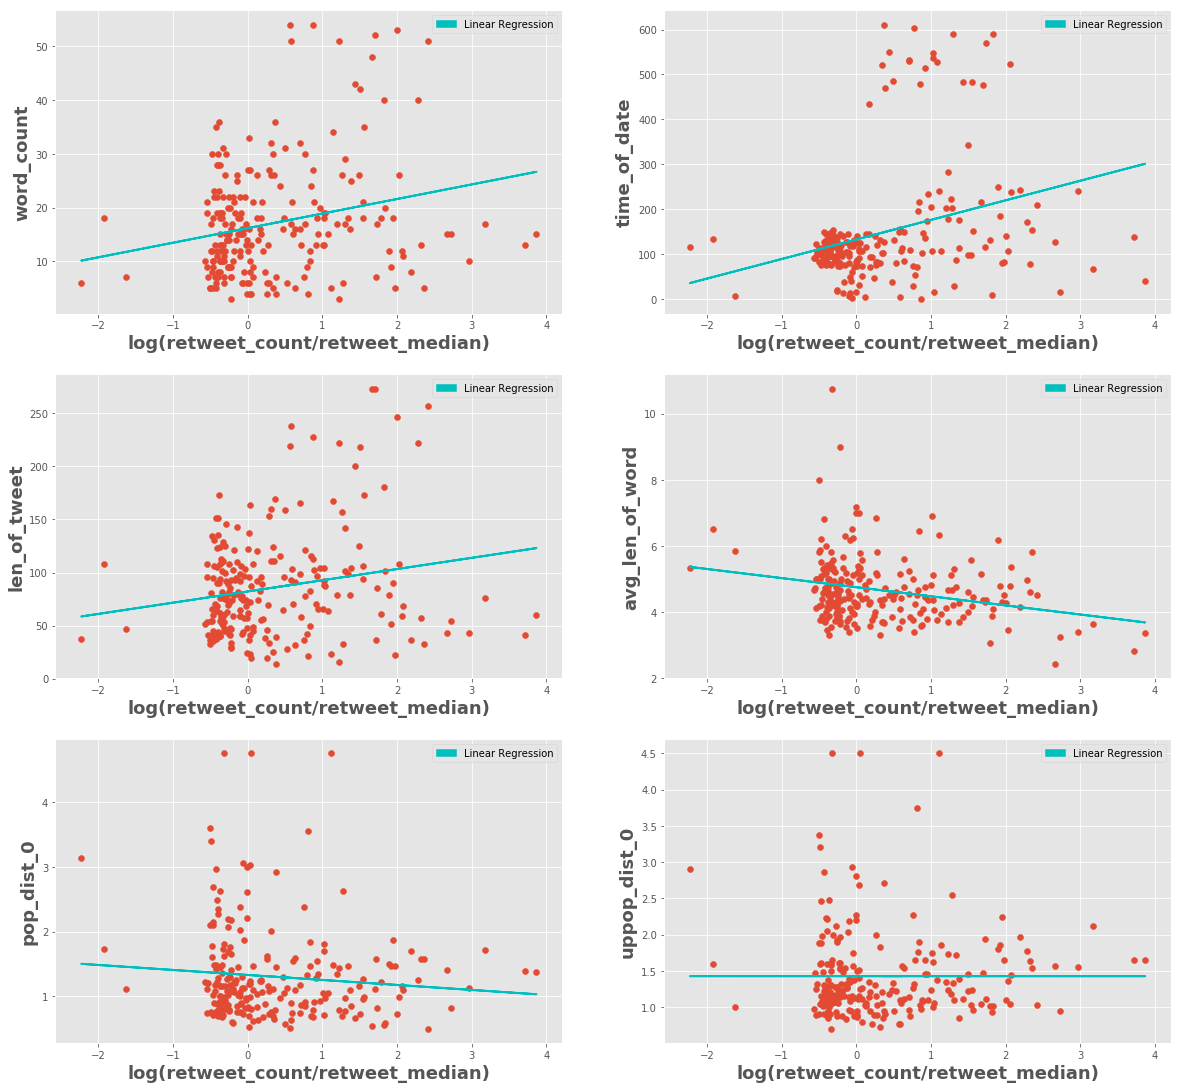

In [22]:
plt.style.use("ggplot")
plot_train_data=train_data.copy()
plot_test_data=test_data.copy()
plot_train_data=plot_train_data[plot_train_data["screen_name"]=="katyperry"]
plot_test_data=plot_test_data[plot_test_data["screen_name"]=="katyperry"]
ploting_col=["word_count","time_of_date","len_of_tweet","avg_len_of_word",'pop_dist_0',"uppop_dist_0"]
plt.figure(num=3, figsize=(20,19))
for i in range(len(ploting_col)):
    ax=plt.subplot(3,2,i+1)
    x=list(np.log(plot_train_data["diff"]))
    y=list(plot_train_data[ploting_col[i]])
    reg = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
    pred = reg.predict(np.array(x).reshape(- 1, 1))
    ax.plot(x, pred, linewidth = 2,c ="c")
    plt.scatter(x, y)
    plt.xlabel('log(retweet_count/retweet_median)', fontsize=18,fontweight='bold')
    plt.ylabel(ploting_col[i],fontsize=18,fontweight='bold')
    leg= mpatches.Patch(color='c', label='Linear Regression')
    plt.legend(handles=[leg])
#     ax.imshow(plt)
plt.show()

In [23]:
feature_columns=['perplexity','word_count', 'hashtag_num', 'link_num',
       'mention_num', 'time_of_date', 'len_of_tweet', 'avg_len_of_word',
        'twitter_tf','this_tf', 'to_tf','how_tf','great_tf', 'check_tf',
       'retweet_tf', 'free_tf','blog_tf', '?_tf', 'help_tf', 'post_tf',
        'top_tf','please_tf','out_tf', 'social_tf','10_tf',
        'follow_tf', 'you_tf',
       'vote_tf','people_tf', 'media_tf', 'pop_dist_0', 'uppop_dist_0', 'pop_dist_1',
       'uppop_dist_1', 'pop_dist_2', 'uppop_dist_2', 'pop_dist_3',
       'uppop_dist_3', 'pop_dist_4', 'uppop_dist_4','positive_word',"negative_word"]

Use validation datasert to choose the best n_estimators.

In [24]:
from sklearn.model_selection import train_test_split
vali_data, real_test_data= train_test_split(test_data,test_size=0.5, random_state=2018)

In [26]:
n_e=[100,150,200,250,300,350,400]
result=[]
for i in n_e:
    clf = RandomForestClassifier(n_estimators=i)  
    RandomForestModel= clf.fit(train_data[feature_columns],train_data["target"])
    r = clf.score(vali_data[feature_columns], vali_data["target"])  
    print("n_estimators:",i," accuracy:",r)

n_estimators: 100  accuracy: 0.756848291663
n_estimators: 150  accuracy: 0.756250622572
n_estimators: 200  accuracy: 0.757346349238
n_estimators: 250  accuracy: 0.756250622572
n_estimators: 300  accuracy: 0.757645183783
n_estimators: 350  accuracy: 0.757645183783
n_estimators: 400  accuracy: 0.757147126208


In [229]:
clf = RandomForestClassifier(n_estimators=300)  
RandomForestModel= clf.fit(train_data[feature_columns],train_data["target"])
r = clf.score(real_test_data[feature_columns], real_test_data["target"])  
print("accuracy",r)

accuract 0.7642430278884462


In [237]:
print("number of features used: ",len(feature_columns))

number of features used:  42


Following is the importance of all features. We list all features' importace scores and plot a bar graph representing their importace scores

                 importance
feature                    
blog_tf            0.000040
?_tf               0.000426
retweet_tf         0.000426
follow_tf          0.000462
vote_tf            0.000632
post_tf            0.000640
social_tf          0.000668
free_tf            0.000700
check_tf           0.000719
media_tf           0.000839
top_tf             0.000875
twitter_tf         0.000920
10_tf              0.000975
please_tf          0.001022
help_tf            0.001430
great_tf           0.001756
people_tf          0.002536
how_tf             0.002612
out_tf             0.002852
this_tf            0.004876
you_tf             0.006350
hashtag_num        0.009057
negative_word      0.010695
to_tf              0.010892
link_num           0.011825
mention_num        0.013626
positive_word      0.014397
word_count         0.041082
pop_dist_3         0.047174
uppop_dist_1       0.047707
pop_dist_1         0.047795
uppop_dist_3       0.047956
uppop_dist_2       0.048153
pop_dist_2         0

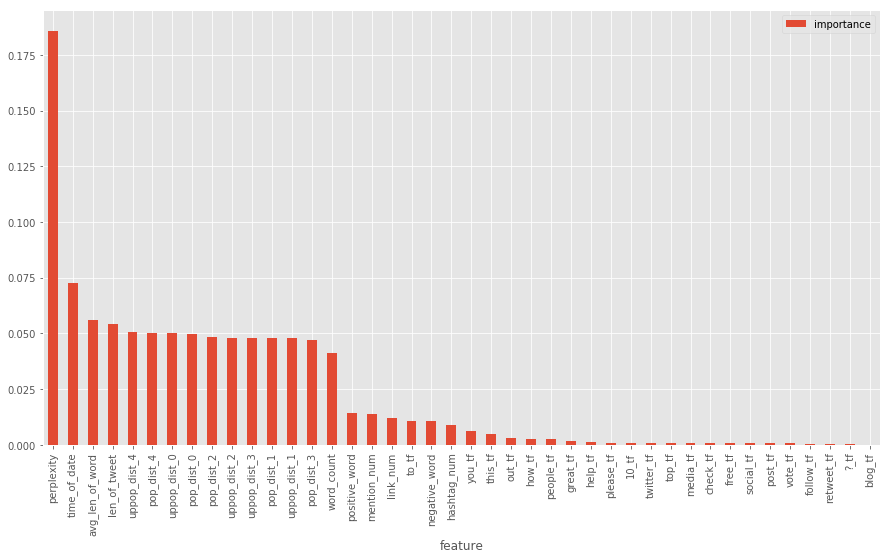

In [256]:
feature_importance=pd.DataFrame({"importance":clf.feature_importances_,"feature":train_data[feature_columns].columns})
feature_importance=feature_importance.set_index("feature")
print(feature_importance.sort_values(by="importance"))
feature_importance.sort_values(by="importance",ascending=False).plot.bar()

### Conclusion
According to the experiment above, we can see that advanced features (perplexity and SIF embedding vector didtances) whcih capture high-level differences between popular and unpopular tweets has relatively higher importances, which prove that higher-level information will be more helpful for this problem. And some basic features like publishing time of a day, average length of word and length of the tweet also contribute much information.

## Future Work

- Currently, our work can only tell whether or not a tweet will become more popular than as usual, but a better usecase would be to tell the user some more specific instructions on how to make the tweet more popular. 
- Deep Learning has been widely applied to the data science area, using deep neural network to extract features from the tweet text may produce better result in our case.

###  Reference
1. Twitter: [https://twitter.com](https://twitter.com)
2. Sean, Ryan, Alex, et al. "Twitter Retweet Prediction" 2016. Available: https://sites.google.com/site/learningtweetvalue/home
3. Hong, Liangjie, Aziz S. Doumith, and Brian D. Davison. "Co-factorization machines: modeling user interests and predicting individual decisions in twitter." _Proceedings of the sixth ACM international conference on Web search and data mining_. ACM, 2013. 
4. Petrovic, Sasa, Miles Osborne, and Victor Lavrenko. "RT to Win! Predicting Message Propagation in Twitter." ICWSM 11 (2011): 586-589.
5. Zhang, Qi, et al. "Retweet prediction with attention-based deep neural network." _Proceedings of the 25th ACM International on Conference on Information and Knowledge Management_. ACM, 2016.
6. Arora, Sanjeev, et al. "A latent variable model approach to pmi-based word embeddings." Transactions of the Association for Computational Linguistics_4 (2016): 385-399.
7.  L.  Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.
8.  Chenhao Tan, Lillian Lee, Bo Pang, The effect of wording on message propagation: Topic- and author-controlled natural experiments on Twitter, ACL'2014